In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

In [2]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/1D_Extractions_updated/PG1522m1/'

Load in the galaxy eigenspectra

In [3]:
eigenspec_df = pd.read_csv('/Users/thepoetoftwilight/Documents/CUBS/Data/Eigenspectra/eigen_galaxy_Bolton2012.csv')

In [4]:
wav_eigen = eigenspec_df['wav']
c1 = eigenspec_df['c1']
c2 = eigenspec_df['c2']
c3 = eigenspec_df['c3']
c4 = eigenspec_df['c4']

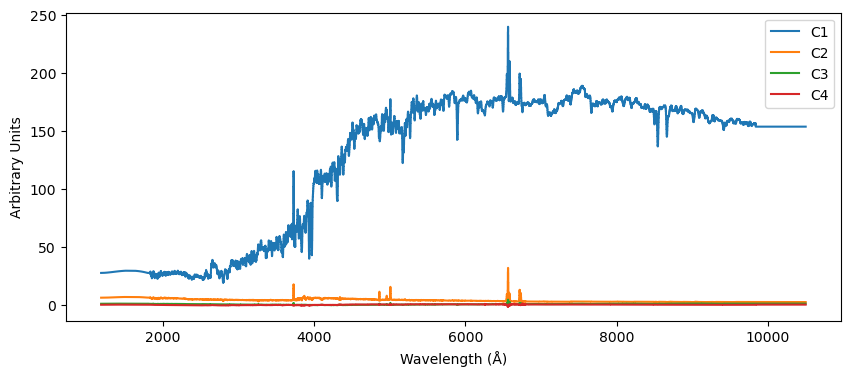

In [5]:
fig, ax = plt.subplots(1, figsize=(10,4))

ax.step(wav_eigen, c1, label='C1', where='mid')
ax.step(wav_eigen, c2, label='C2', where='mid')
ax.step(wav_eigen, c3, label='C3', where='mid')
ax.step(wav_eigen, c4, label='C4', where='mid')

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Arbitrary Units')

ax.legend()

Functions to load up 1D spectra

In [6]:
def load_spec_1d(rootdir, slit_num):
    
    spec_1d = fits.open(rootdir + '{}_1dspec.fits'.format(slit_num))
    
    wav0 = spec_1d[0].header['CRVAL1']
    delta_wav = spec_1d[0].header['CDELT1']
    
    flux = spec_1d[0].data[4,:]
    err = spec_1d[0].data[5,:]
    
    wav = np.arange(wav0, wav0+len(flux)*delta_wav, delta_wav)
    
    return wav, flux, err

In [7]:
def plot_spec(ax, rootdir, slit_num):
    
    wav, flux, err = load_spec_1d(rootdir, slit_num)
    ax.step(wav, flux, where='mid', color='black')
    ax.step(wav, err, where='mid', color='cyan')
    ax.set_title('SLIT {}'.format(slit_num))
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Arbitrary Units')
    
    return wav, flux, err

(-1000.0, 3000.0)

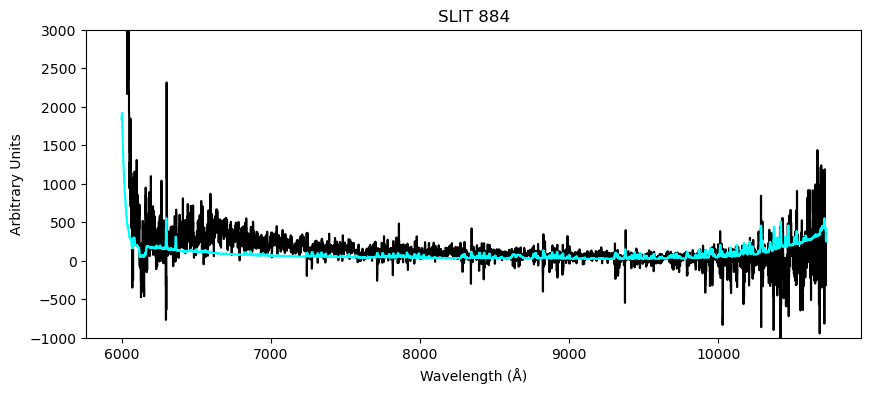

In [8]:
fig, ax = plt.subplots(1, figsize=(10, 4))
wav, flux, err = plot_spec(ax, rootdir, 884)
ax.set_ylim(-1000,3000)

Now do the redshift fitting

In [9]:
def z_shift_eigen(z, wav_arr):
    
    wav_eigen_shift = wav_eigen*(1+z)
    
    gal_ind = (wav_eigen_shift>=wav_arr[0])&(wav_eigen_shift<=wav_arr[-1])
    wav_eigen_shift_gal = wav_eigen_shift[gal_ind]
    
    c1_gal = c1[gal_ind]
    c1_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c1_gal)

    c2_gal = c2[gal_ind]
    c2_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c2_gal)
    
    c3_gal = c3[gal_ind]
    c3_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c3_gal)

    c4_gal = c4[gal_ind]
    c4_gal_interp = np.interp(wav_arr, wav_eigen_shift_gal, c4_gal)
    
    return c1_gal_interp, c2_gal_interp, c3_gal_interp, c4_gal_interp

In [10]:
def best_model(c1, c2, c3, c4, y, y_err):

    A11 = np.sum((c1/y_err)**2)
    A12 = np.sum(c1*c2/y_err**2)
    A13 = np.sum(c1*c3/y_err**2)
    A14 = np.sum(c1*c4/y_err**2)
    
    A21 = np.sum(c2*c1/y_err**2)
    A22 = np.sum((c2/y_err)**2)
    A23 = np.sum(c2*c3/y_err**2)
    A24 = np.sum(c2*c4/y_err**2)
    
    A31 = np.sum(c3*c1/y_err**2)
    A32 = np.sum(c3*c2/y_err**2)
    A33 = np.sum((c3/y_err)**2)
    A34 = np.sum(c3*c4/y_err**2)
    
    A41 = np.sum(c4*c1/y_err**2)
    A42 = np.sum(c4*c2/y_err**2)
    A43 = np.sum(c4*c3/y_err**2)
    A44 = np.sum((c4/y_err)**2)
    
    b1 = np.sum(y*c1/y_err**2)
    b2 = np.sum(y*c2/y_err**2)
    b3 = np.sum(y*c3/y_err**2)
    b4 = np.sum(y*c4/y_err**2)
    
    A_mat = np.array([[A11, A12, A13, A14],[A21, A22, A23, A24],[A31, A32, A33, A34],[A41, A42, A43, A44]])
    b_vec = np.array([b1, b2, b3, b4])
    
    x_vec = np.linalg.inv(A_mat)@b_vec
    
    a = x_vec[0]
    b = x_vec[1]
    c = x_vec[2]
    d = x_vec[3]

    return a, b, c, d

In [11]:
def eval_red_chi_sq(y_hat, y, y_err, dof):
    
    return np.sum(((y-y_hat)/y_err)**2)/(len(y)-dof)

In [24]:
z_arr = np.arange(0,1.4,1e-4)
red_chi_sq_arr = np.zeros(len(z_arr))

In [25]:
model_params = np.zeros((len(z_arr), 4))

In [26]:
idx = ~np.isnan(flux)

In [27]:
for i in range(len(z_arr)):
    
    z = z_arr[i]
    
    c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav[idx][60:-60])
    
    a, b, c, d = best_model(c1_shift, c2_shift, c3_shift, c4_shift, 
                            flux[idx][60:-60], err[idx][60:-60])
    
    model_params[i,0] = a
    model_params[i,1] = b
    model_params[i,2] = c
    model_params[i,3] = d 
    
    red_chi_sq = eval_red_chi_sq(a*c1_shift+b*c2_shift+c*c3_shift+d*c4_shift, 
                                        flux[idx][60:-60], err[idx][60:-60], model_params.shape[1])
    
    red_chi_sq_arr[i] = red_chi_sq
    
    #print(a, b, c, d, red_chi_sq)

Text(0, 0.5, '$\\chi^2$')

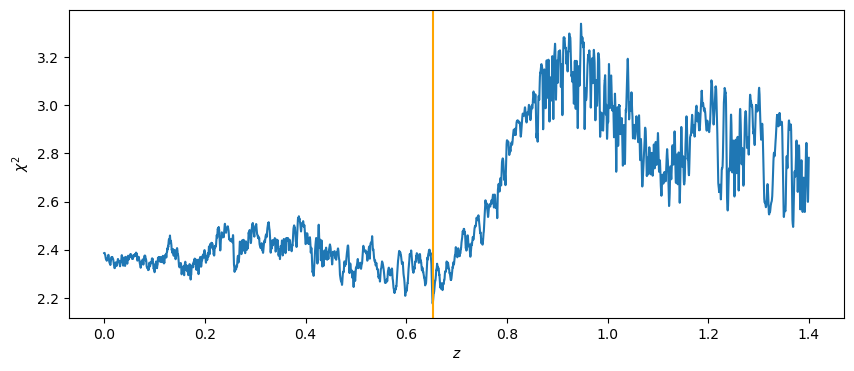

In [28]:
fig, ax = plt.subplots(1, figsize=(10,4))

ax.plot(z_arr, red_chi_sq_arr)
ax.axvline(z_arr[np.argmin(red_chi_sq_arr)],color='orange')

ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$\chi^2$')

0.6526000000000001 2.175837545458581


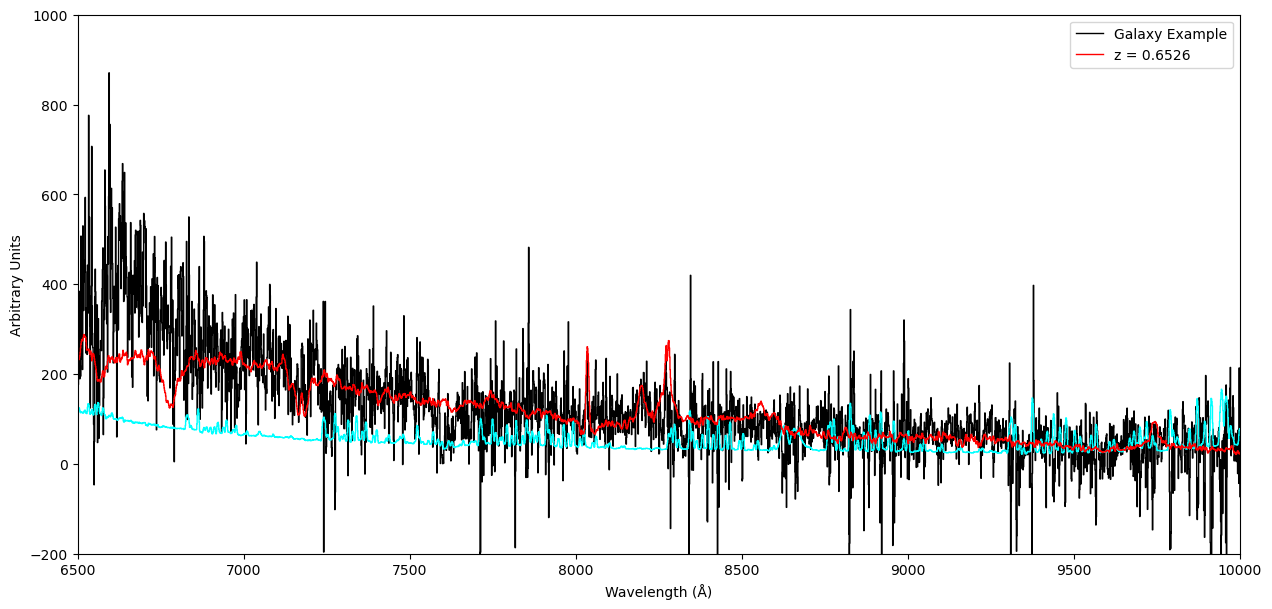

In [34]:
fig, ax = plt.subplots(1, figsize=(15,7))

ax.step(wav[idx][60:-60], flux[idx][60:-60], label='Galaxy Example', color='black', where='mid', lw=1)
ax.step(wav[idx][60:-60], err[idx][60:-60], color='cyan', where='mid', lw=1)

z = z_arr[np.argmin(red_chi_sq_arr)]

print(z, np.min(red_chi_sq_arr))

c1_shift, c2_shift, c3_shift, c4_shift = z_shift_eigen(z, wav)

ax.step(wav, model_params[np.argmin(red_chi_sq_arr),0]*c1_shift + model_params[np.argmin(red_chi_sq_arr),1]*c2_shift + model_params[np.argmin(red_chi_sq_arr),2]*c3_shift + model_params[np.argmin(red_chi_sq_arr),3]*c4_shift, 
        label='z = ' + str(np.round(z,4)), where='mid', color='red', lw=1)

ax.set_xlabel('Wavelength (Å)')
ax.set_ylabel('Arbitrary Units')

ax.set_xlim(6500, 10000)
ax.set_ylim(-200,1000)

ax.legend()

Slit 385

(-1000.0, 3000.0)

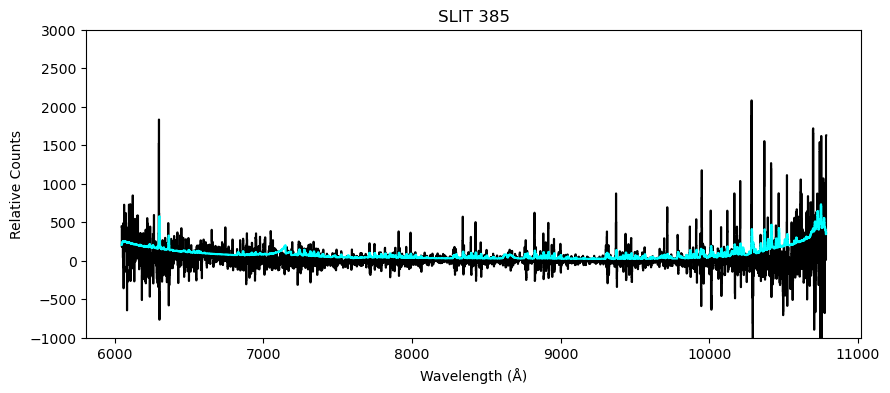

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 385)
ax.set_ylim(-1000,3000)

(-1000.0, 2000.0)

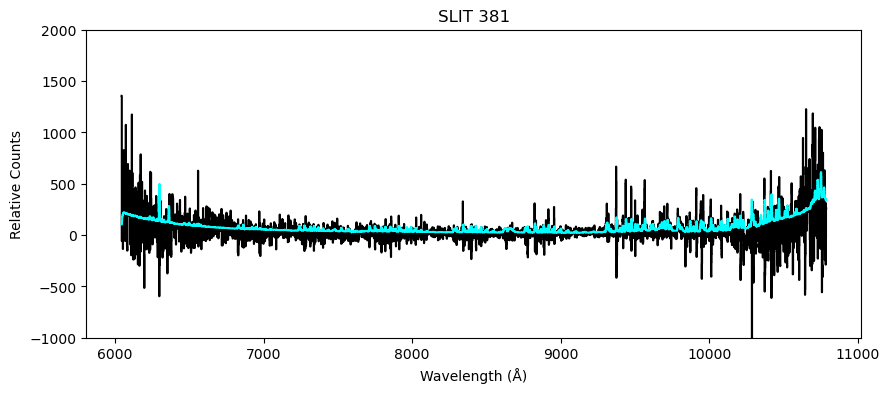

In [14]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 381)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

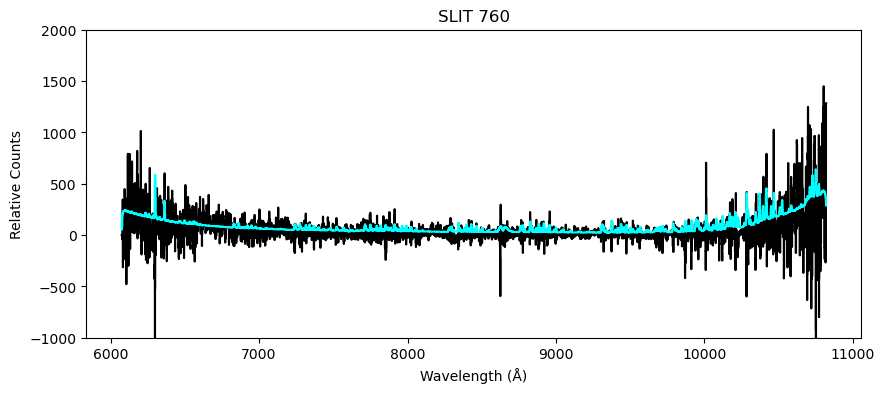

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 760)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

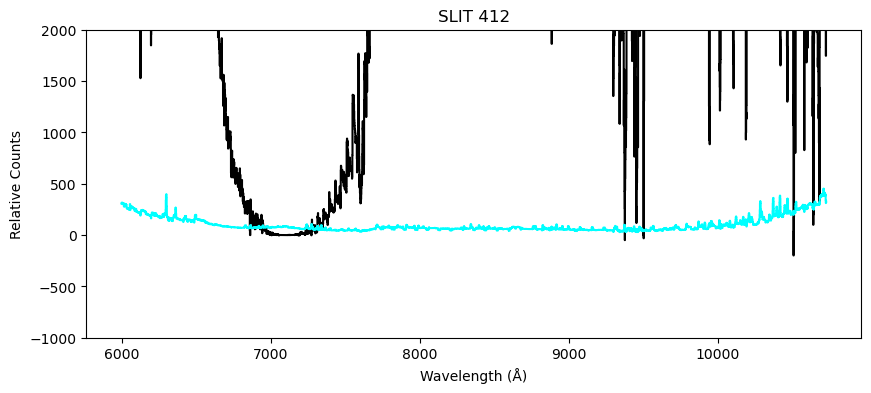

In [18]:
# Bad slit
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 412)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

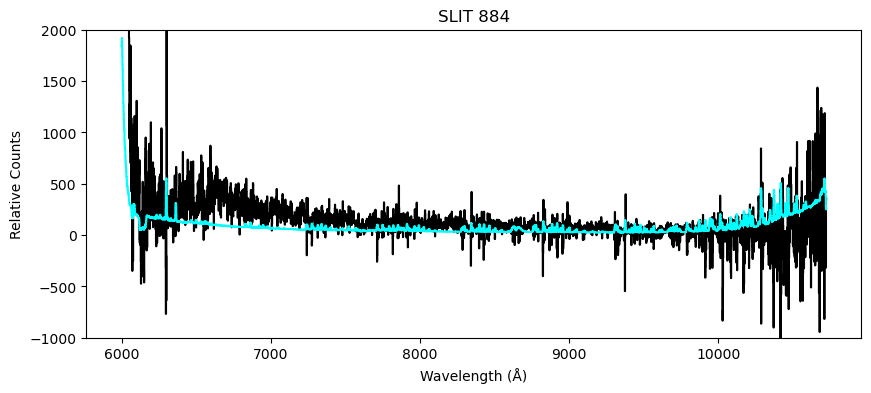

In [20]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 884)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

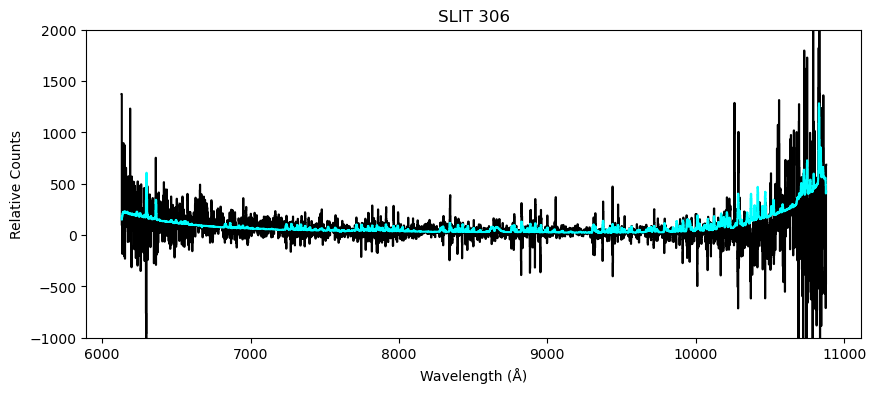

In [21]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 306)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

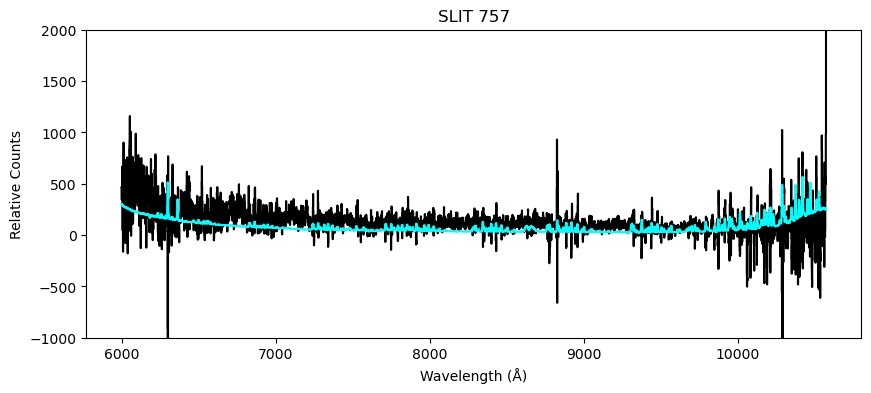

In [23]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 757)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

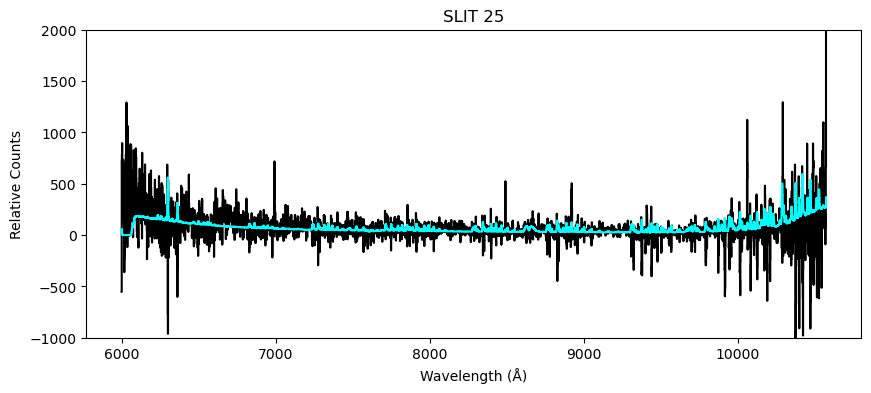

In [24]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 25)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

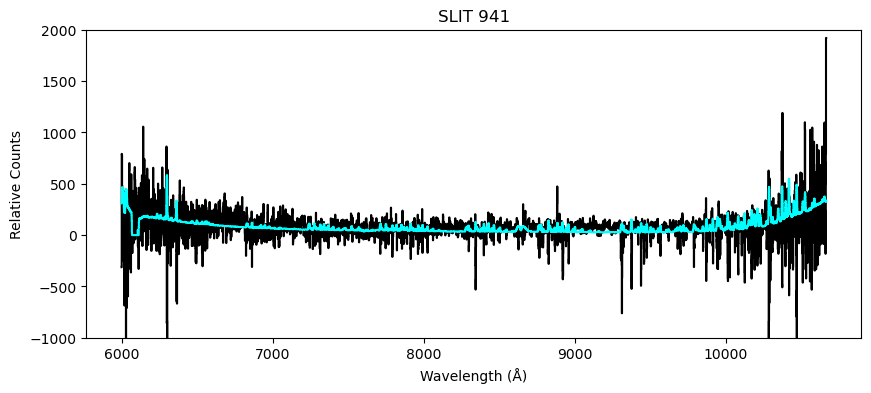

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 941)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

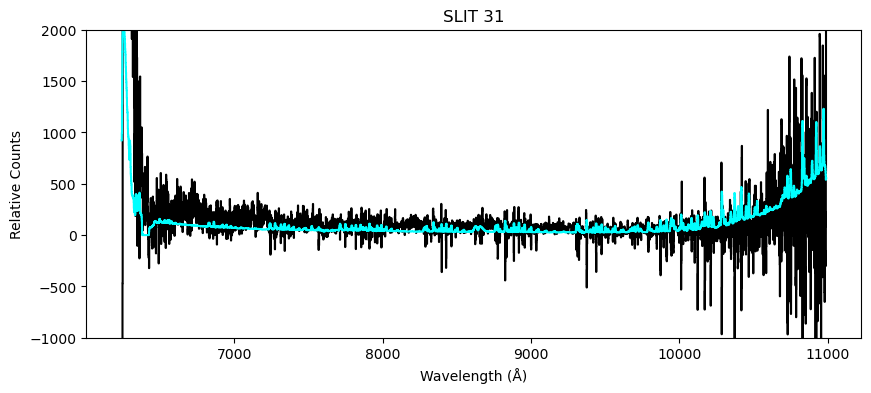

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 31)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

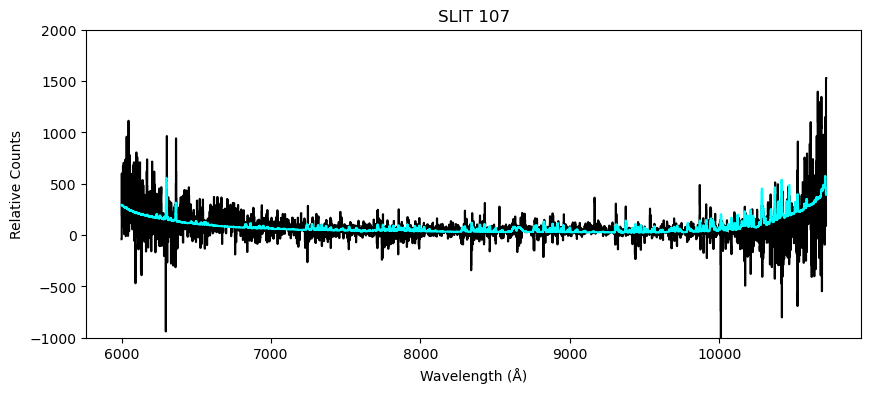

In [27]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 107)
ax.set_ylim(-1000,2000)

(-1000.0, 2000.0)

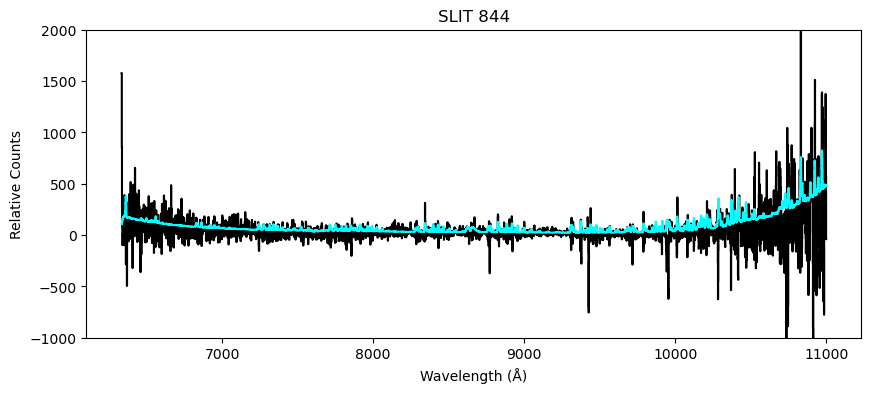

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 4))
plot_spec(ax, rootdir, 844)
ax.set_ylim(-1000,2000)